In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from scipy.optimize import minimize


In [ ]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load dataset (example: Apple stock prices from Yahoo Finance)
df = yf.download('AAPL', start='2015-01-01', end='2025-04-15')

# Keep only the 'Close' price and reset index
df = df[['Close']].reset_index()

# Check for missing values
df = df.dropna()

# Data Preparation for Prophet
df_prophet = df.rename(columns={'Date': 'ds', 'Close': 'y'})

df_prophet.columns = ['ds', 'y']  # Rename correctly


[*********************100%***********************]  1 of 1 completed


In [ ]:
# Ensure correct data types
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
df_prophet['y'] = pd.to_numeric(df_prophet['y'], errors='coerce')

# ✅ Data Preparation for ARIMA (Keep 'Close' as Series)
df_arima = df[['Close']]

# Normalize data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm = scaler.fit_transform(df[['Close']])

# ✅ Split data for training/testing
train_size = int(len(df) * 0.8)

# Prophet
train_prophet, test_prophet = df_prophet[:train_size], df_prophet[train_size:]

# ARIMA
train_arima, test_arima = df_arima[:train_size], df_arima[train_size:]

# LSTM
train_lstm, test_lstm = df_lstm[:train_size], df_lstm[train_size:]

# Print data overview
print(f"Dataset shape: {df.shape}")
print(f"Training size: {train_size}, Testing size: {len(df) - train_size}")
print(df.head())  # Verify first few rows


Dataset shape: (2586, 2)
Training size: 2068, Testing size: 518
Price        Date      Close
Ticker                  AAPL
0      2015-01-02  24.320440
1      2015-01-05  23.635292
2      2015-01-06  23.637516
3      2015-01-07  23.968958
4      2015-01-08  24.889906


In [ ]:
print(type(train_prophet))  # Should be <class 'pandas.DataFrame'>
print(train_prophet.columns)  # Check if 'y' and 'ds' exist
print(train_prophet.head())  # See first few rows


<class 'pandas.core.frame.DataFrame'>
Index(['ds', 'y'], dtype='object')
          ds          y
0 2015-01-02  24.320440
1 2015-01-05  23.635292
2 2015-01-06  23.637516
3 2015-01-07  23.968958
4 2015-01-08  24.889906


In [ ]:
print(df_prophet.shape)  # Check original dataset size
print(train_prophet.shape)  # Check train set size


(2586, 2)
(2068, 2)


In [ ]:
# --------------------- Prophet Model ---------------------
prophet = Prophet()
prophet.fit(train_prophet)

future = prophet.make_future_dataframe(periods=len(test_prophet))
forecast_prophet = prophet.predict(future)
pred_prophet = forecast_prophet['yhat'].iloc[-len(test_prophet):].values



INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp09i5s9ec/w1dtpv8t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp09i5s9ec/rhs8pn6e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36933', 'data', 'file=/tmp/tmp09i5s9ec/w1dtpv8t.json', 'init=/tmp/tmp09i5s9ec/rhs8pn6e.json', 'output', 'file=/tmp/tmp09i5s9ec/prophet_modelvp5kngrm/prophet_model-20250416152226.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:22:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:22:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# --------------------- ARIMA Model ---------------------
arima_order = (5, 1, 0)  # You can optimize this using auto_arima
model_arima = ARIMA(train_arima, order=arima_order)
model_arima_fit = model_arima.fit()
pred_arima = model_arima_fit.forecast(steps=len(test_arima))

# --------------------- LSTM Model ---------------------
def create_sequences(data, seq_length=60):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

seq_length = 60
x_train, y_train = create_sequences(train_lstm, seq_length)
x_test, y_test = create_sequences(test_lstm, seq_length)

# Reshape for LSTM input
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# LSTM model definition
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train LSTM model
lstm_model.fit(x_train, y_train, epochs=100, batch_size=16, verbose=1)

# Predict with LSTM
lstm_predictions = lstm_model.predict(x_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

# Align predictions with actual data length
pred_lstm = np.concatenate([np.full((seq_length, 1), np.nan), lstm_predictions])



Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0155
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.2073e-04
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.4509e-04
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.0291e-04
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.8584e-04
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.7303e-04
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.8054e-04
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.1756e-04
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.3332e-04
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.4469e-04
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.8883e-04
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.8864e-04
Epoch 13/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.7952e-04
Epoch 14/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6190e-04


In [ ]:
# Find the minimum length among all predictions
min_length = min(len(pred_prophet), len(pred_arima), len(pred_lstm[seq_length:].flatten()))

# Align all predictions to the same length
pred_prophet = pred_prophet[-min_length:]
pred_arima = pred_arima[-min_length:]
pred_lstm = pred_lstm[seq_length:].flatten()[-min_length:]

# Hybrid Model (Weighted Average)
weight_prophet = 0.4
weight_arima = 0.4
weight_lstm = 0.3

hybrid_pred = (weight_prophet * pred_prophet) + (weight_arima * pred_arima) + (weight_lstm * pred_lstm)

print(f"Hybrid Prediction Length: {len(hybrid_pred)}")


Hybrid Prediction Length: 458


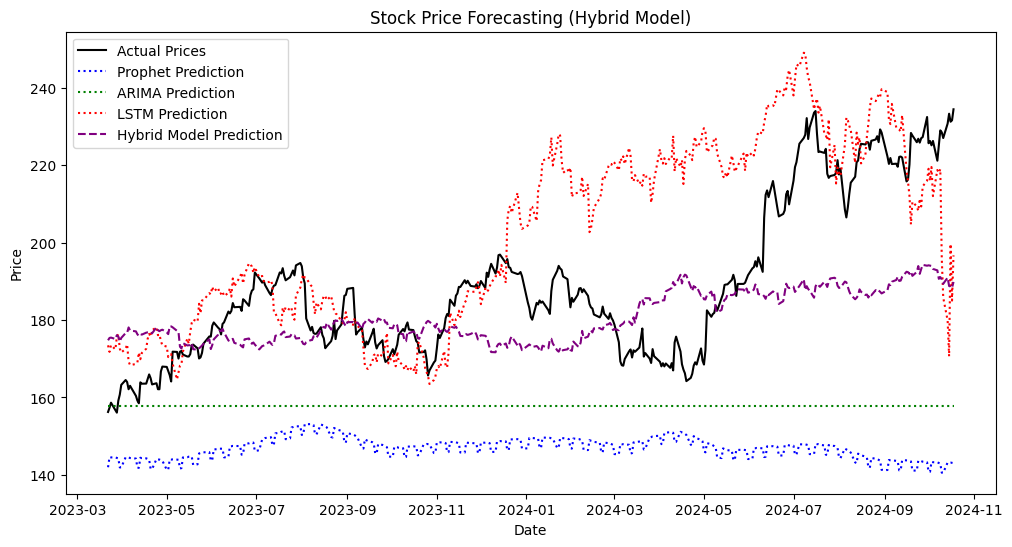

In [ ]:
# Find the minimum length among all datasets
min_length = min(len(df['Date'].iloc[train_size:]),
                 len(pred_prophet),
                 len(pred_arima),
                 len(pred_lstm[seq_length:]),
                 len(hybrid_pred))

# Align the predictions to match the minimum length
dates = df['Date'].iloc[train_size:].iloc[:min_length]
actual_prices = df['Close'].iloc[train_size:].iloc[:min_length]
pred_prophet = pred_prophet[:min_length]
pred_arima = pred_arima[:min_length]
pred_lstm = pred_lstm[seq_length:][:min_length]
hybrid_pred = hybrid_pred[:min_length]

# --------------------- Plot Results ---------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(dates, actual_prices, label="Actual Prices", color='black')
plt.plot(dates, pred_prophet, label="Prophet Prediction", linestyle="dotted", color='blue')
plt.plot(dates, pred_arima, label="ARIMA Prediction", linestyle="dotted", color='green')
plt.plot(dates, pred_lstm, label="LSTM Prediction", linestyle="dotted", color='red')
plt.plot(dates, hybrid_pred, label="Hybrid Model Prediction", linestyle="dashed", color='purple')

plt.legend()
plt.title("Stock Price Forecasting (Hybrid Model)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

# Ensure all arrays are 1D
actual_prices = np.ravel(actual_prices)
pred_prophet = np.ravel(pred_prophet)
pred_arima = np.ravel(pred_arima)
pred_lstm = np.ravel(pred_lstm)
hybrid_pred = np.ravel(hybrid_pred)

# Find the minimum length across actual and predictions
min_length = min(len(actual_prices), len(pred_prophet), len(pred_arima), len(pred_lstm[seq_length:]), len(hybrid_pred))

# Trim all arrays to match the shortest length
actual_trimmed = actual_prices[:min_length]
pred_prophet_trimmed = pred_prophet[:min_length]
pred_arima_trimmed = pred_arima[:min_length]
pred_lstm_trimmed = pred_lstm[seq_length:][:min_length]
hybrid_pred_trimmed = hybrid_pred[:min_length]

# Compute MAE for each model
mae_prophet = mean_absolute_error(actual_trimmed, pred_prophet_trimmed)
mae_arima = mean_absolute_error(actual_trimmed, pred_arima_trimmed)
mae_lstm = mean_absolute_error(actual_trimmed, pred_lstm_trimmed)
mae_hybrid = mean_absolute_error(actual_trimmed, hybrid_pred_trimmed)

# Create a DataFrame to compare actual vs predicted prices
df_comparison = pd.DataFrame({
    "Actual Price": actual_trimmed.flatten(),
    "Prophet Prediction": pred_prophet_trimmed.flatten(),
    "ARIMA Prediction": pred_arima_trimmed.flatten(),
    "LSTM Prediction": pred_lstm_trimmed.flatten(),
    "Hybrid Model Prediction": hybrid_pred_trimmed.flatten()
})

# Print first few rows of the comparison table
print(df_comparison.head(10))

# Print MAE results
print("\nMean Absolute Error (MAE):")
print(f"MAE - Prophet: {mae_prophet:.2f}")
print(f"MAE - ARIMA: {mae_arima:.2f}")
print(f"MAE - LSTM: {mae_lstm:.2f}")
print(f"MAE - Hybrid Model: {mae_hybrid:.2f}")


   Actual Price  Prophet Prediction  ARIMA Prediction  LSTM Prediction  \
0    156.254227          141.967228        157.720462       188.670578   
1    157.343216          144.587014        157.720462       191.237350   
2    158.650070          144.508431        157.720462       192.305145   
3    156.699722          144.498494        157.720462       189.440964   
4    156.076004          144.381748        157.720462       191.708344   
5    159.164871          144.258226        157.720462       194.705627   
6    160.738968          141.920582        157.720462       194.268921   
7    163.253616          141.920839        157.720462       193.869583   
8    164.510925          144.560858        157.720462       192.198318   
9    163.976349          144.491510        157.720462       193.663589   

   Hybrid Model Prediction  
0               174.779233  
1               175.386279  
2               175.476762  
3               175.119293  
4               176.089311  
5          

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ensure all arrays are 1D
actual_prices = np.ravel(actual_prices)
pred_prophet = np.ravel(pred_prophet)
pred_arima = np.ravel(pred_arima)
pred_lstm = np.ravel(pred_lstm)
hybrid_pred = np.ravel(hybrid_pred)

# Find the minimum length across actual and predictions
min_length = min(
    len(actual_prices),
    len(pred_prophet),
    len(pred_arima),
    len(pred_lstm[seq_length:]),
    len(hybrid_pred)
)

# Trim all arrays to match the shortest length
actual_trimmed = actual_prices[:min_length]
pred_prophet_trimmed = pred_prophet[:min_length]
pred_arima_trimmed = pred_arima[:min_length]
pred_lstm_trimmed = pred_lstm[seq_length:][:min_length]
hybrid_pred_trimmed = hybrid_pred[:min_length]

# Function to compute all metrics
def evaluate_model(true, pred):
    mae = mean_absolute_error(true, pred)
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((true - pred) / true)) * 100
    r2 = r2_score(true, pred)
    return mae, mse, rmse, mape, r2

# Evaluate each model
metrics_prophet = evaluate_model(actual_trimmed, pred_prophet_trimmed)
metrics_arima = evaluate_model(actual_trimmed, pred_arima_trimmed)
metrics_lstm = evaluate_model(actual_trimmed, pred_lstm_trimmed)
metrics_hybrid = evaluate_model(actual_trimmed, hybrid_pred_trimmed)

# Create DataFrame to compare actual vs predicted prices
df_comparison = pd.DataFrame({
    "Actual Price": actual_trimmed.flatten(),
    "Prophet Prediction": pred_prophet_trimmed.flatten(),
    "ARIMA Prediction": pred_arima_trimmed.flatten(),
    "LSTM Prediction": pred_lstm_trimmed.flatten(),
    "Hybrid Model Prediction": hybrid_pred_trimmed.flatten()
})

# Print comparison
print(df_comparison.head(10))

# Print Metrics
def print_metrics(name, metrics):
    mae, mse, rmse, mape, r2 = metrics
    print(f"\n{name} Metrics:")
    print(f"MAE:  {mae:.2f}")
    print(f"MSE:  {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R²:   {r2:.4f}")

print_metrics("Prophet", metrics_prophet)
print_metrics("ARIMA", metrics_arima)
print_metrics("LSTM", metrics_lstm)
print_metrics("Hybrid Model", metrics_hybrid)


   Actual Price  Prophet Prediction  ARIMA Prediction  LSTM Prediction  \
0    156.254227          141.967228        157.720462       188.670578   
1    157.343216          144.587014        157.720462       191.237350   
2    158.650070          144.508431        157.720462       192.305145   
3    156.699722          144.498494        157.720462       189.440964   
4    156.076004          144.381748        157.720462       191.708344   
5    159.164871          144.258226        157.720462       194.705627   
6    160.738968          141.920582        157.720462       194.268921   
7    163.253616          141.920839        157.720462       193.869583   
8    164.510925          144.560858        157.720462       192.198318   
9    163.976349          144.491510        157.720462       193.663589   

   Hybrid Model Prediction  
0               174.779233  
1               175.386279  
2               175.476762  
3               175.119293  
4               176.089311  
5          